### AlexNet.

In this notebook we will implement the modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)  a neural network model that uses convolutional neural network (CNN) layers and was designed for the ImageNet challenge. AlexNet is famous for winning the [ImageNet challenge](https://image-net.org/challenges/LSVRC/) in 2012 by beating the second place competitor by over 10% accuracy and kickstarting the interest in deep learning for computer vision.

The image below shows the architecture of AlexNet.

![](https://github.com/bentrevett/pytorch-image-classification/raw/b2e971a52d1478c8d56cb454fc147a3c343eb882/assets/alexnet.png)

Confusingly, there are two "paths" of processing through the network. This is due to the original AlexNet model being implemented on two GPUs in parallel. In this notebook we are going to implement the AlexNet on a single GPU. 

In the [previous notebook](https://github.com/CrispenGari/PyTorch-Python/blob/main/03_Torch_Vision/03_Image_Classification/02_LeNet.ipynb) we used the mnist dataset which consist of images of black and white digits from 0 to 9. This time aroud we will use the `CIFAR10` dataset which consist of 60000 32x32 colored images with 10 classes which are:

```
classes =[ airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]
```

**Note** Also in this notebook we are also going to show how are we going to initialize the weigths to our model and finding a suitable learning rate using the modified version of the [leaning rate](https://arxiv.org/abs/1506.01186)

Like the previous notebooks we'll implement our model, measure its performance on the dataset, and then have a short look into seeing what the model has learned.


### Imports and data prep.

As always, we'll import the modules we need. A new import is the `_LRScheduler` which we will use to implement our learning rate finder.


In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torch.optim.lr_scheduler import _LRScheduler

import random, time, os, copy

import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from prettytable import PrettyTable

torch.__version__

'1.9.0+cu102'

### Seeds

In [2]:

SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Mean and std of the dataset

We are going to calculate the mean and std of the data so that we can normalize it.

**Note**: 
Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently.

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

**Note** We only calculate the means and stds on the train set.

In [ ]:
train_data = datasets.CIFAR10('.',
                              train=True,
                              download=True
                              )
means = train_data.data.mean(axis = (0, 1, 2))/255
stds = train_data.data.std(axis=(0, 1, 2))/255

### Tabulating the means and stds

In [5]:
means

array([0.49139968, 0.48215841, 0.44653091])

In [11]:
def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

tabulate([
    "Measure of Central Tendecy", "Value"
],[
   *[(f"mean {i +1}", mean) for i, mean in enumerate(means)],
   *[(f"std {i +1}", std) for i, std in enumerate(stds)]
], "THE MEAN(s) AND STANDARD DEVIATION(s) OF THE DATA")

+-----------------------------------------------------+
|  THE MEAN(s) AND STANDARD DEVIATION(s) OF THE DATA  |
+------------------------------+----------------------+
| Measure of Central Tendecy   |                Value |
+------------------------------+----------------------+
| mean 1                       |  0.49139967861519607 |
| mean 2                       |  0.48215840839460783 |
| mean 3                       |  0.44653091444546567 |
| std 1                        |  0.24703223246328176 |
| std 2                        |  0.24348512800005648 |
| std 3                        |  0.26158784172796473 |
+------------------------------+----------------------+


### Data Agumentation

The images in the `CIFAR10` dataset are significantly more complex than the `MNIST` dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of 0.5 as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. 

**We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.** The reason we did not use the `RandomHorizontalFlip` data argumentation on the MNIST dataset was because If you flip a digit `6` maybe it will become a `9` therefore this will confuse the model.

As our means and stds are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [12]:
train_transfoms = transforms.Compose([
          transforms.RandomRotation(5),
          transforms.RandomHorizontalFlip(.5),
          transforms.RandomCrop(32, padding=2),
          transforms.ToTensor(),
          transforms.Normalize(mean=means, std=stds, inplace=False)
])

test_transfoms = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=means, std=stds, inplace=False)
])

### Loading the dataset and apply transforms

In [ ]:
train_data = datasets.CIFAR10(
    '.',
    download=True,
    train=True,
    transform = train_transfoms
)
test_data = datasets.CIFAR10(
    '.',
    download=True,
    train=False,
    transform = test_transfoms
)

### Validation set.
Again the CIFAR10 does not come with the validation set therefore we will create the validation set from the train set and we will then overide the train transforms with the test transforms

In [14]:
n_valid = int(len(train_data) * 0.1)
n_train = len(train_data) - n_valid
train_data, valid_data = data.random_split(train_data, [n_train, n_valid])

In [16]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transfoms

In [17]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("training", len(train_data)), ("testing", len(test_data)), ("validation", len(valid_data))
tabulate(columns, data_rows, title)

+--------------------+
| DATASETS EXAMPLES  |
+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   | 45000 |
| testing    | 10000 |
| validation |  5000 |
+------------+-------+


### Next we will create a `plot_images` function
This function will helps us to visualize our images.

**Note** that by default PyTorch handles images that are arranged ``[channel, height, width]``, but matplotlib expects images to be ``[height, width, channel]``, hence we need to permute our images before plotting them.

In [22]:
def plot_images(images, labels, classes, normalize=False):

  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize = (8, 8))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    
    if normalize:
      image_min = image.min()
      image_max = image.max()
      image.clamp_(min=image_min, max=image_max)
      image.add_(-image_min).div_(image_max - image_min + 1e-5)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')


Then, we'll actually plot the images.

We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's classes dictionary.

When we plot them we see lots of warnings. This is because matplotlib is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default matplotlib will then clip these values into the $[0,1]$ range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

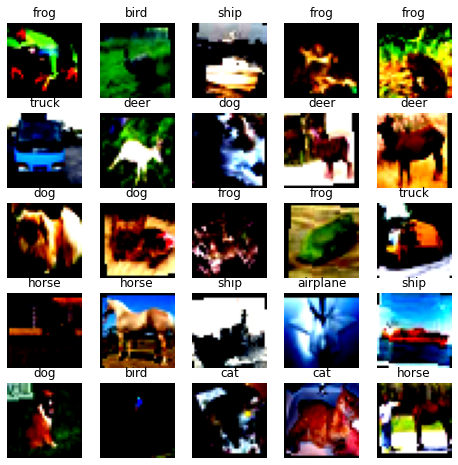

In [23]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes
plot_images(images, labels, classes)

### Normalizing the images.

Remember our `plot_images` function takes an argument `nomalize` which is by default set to false. When we set that to true then all images will be ploted nicely and they will be visible.

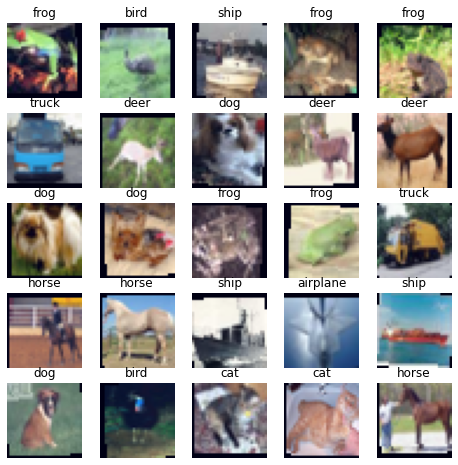

In [24]:
plot_images(images, labels, classes, normalize = True)

We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [41]:
def normalize_images(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min=image_min, max=image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

As before, we'll check what images look like with Sobel filters applied to them.

In [42]:
def plot_filter(images, filter, normalize=True):
  images = torch.cat([
      i.unsqueeze(0) for i in images
  ], dim =0).cpu()
  filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
  filter = filter.repeat(3, 3, 1, 1)
  n_images = images.shape[0]
  filtered_images = F.conv2d(images, filter)
  images = images.permute(0, 2, 3, 1)
  filtered_images = filtered_images.permute(0, 2, 3, 1)
  fig = plt.figure(figsize = (25, 5))

  for i in range(n_images):
    image = images[i]
    if normalize:
        image = normalize_images(image)

    ax = fig.add_subplot(2, n_images, i+1)
    ax.imshow(image)
    ax.set_title('Original')
    ax.axis('off')

    image = filtered_images[i]
    if normalize:
        image = normalize_images(image)
    ax = fig.add_subplot(2, n_images, n_images+i+1)
    ax.imshow(image)
    ax.set_title(f'Filtered')
    ax.axis('off');

The filters are still 2-dimensional but they are expanded to a depth of three dimensions inside the `plot_filter` function.

Below is a filter which detects horizontal lines.

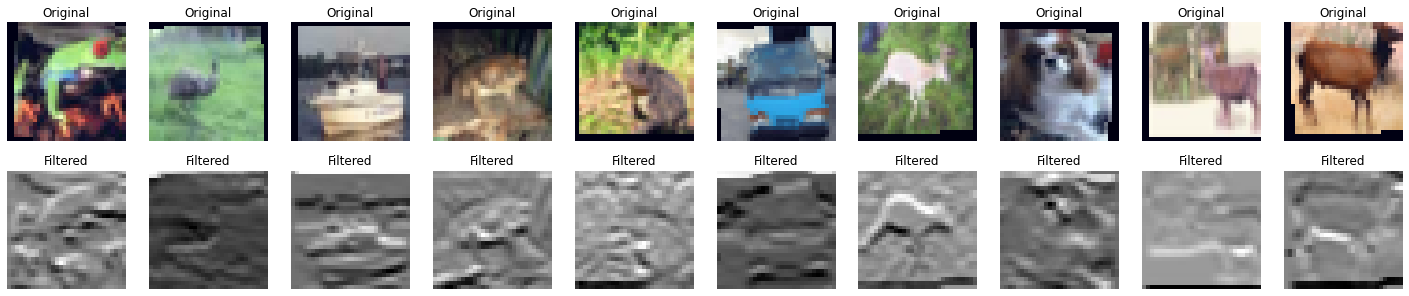

In [43]:
N_IMAGES = 10
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]
plot_filter(images, horizontal_filter)


A filter that detects vertical lines

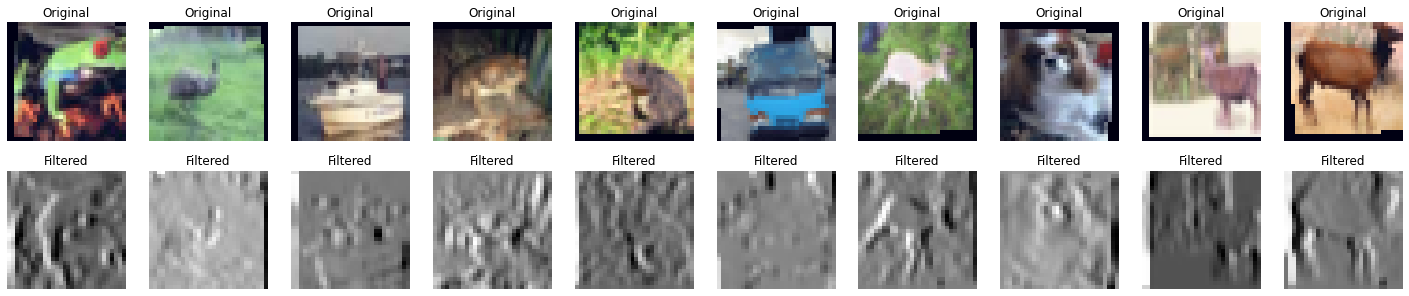

In [44]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]
plot_filter(images, vertical_filter)

### Sampling and pooling

We'll also do the same for subsampling/pooling.

In [45]:
def plot_subsample(images, pool_type, pool_size, normalize = True):
    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    
    if pool_type.lower() == "max":
      pool = F.max_pool2d
    elif pool_type.lower() in ["mean", "avg"]:
      pool = F.avg_pool2d
    else:
      raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')
      
    n_images = images.shape[0]
    pooled_images = pool(images, kernel_size = pool_size)
    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize = (25, 5))
    for i in range(n_images):
      image = images[i]
      if normalize:
          image = normalize_images(image)
      ax = fig.add_subplot(2, n_images, i+1)
      ax.imshow(image)
      ax.set_title('Original')
      ax.axis('off')

      image = pooled_images[i]
      if normalize:
          image = normalize_images(image)
      ax = fig.add_subplot(2, n_images, n_images+i+1)
      ax.imshow(image)
      ax.set_title(f'Subsampled')
      ax.axis('off');
      

As before, the higher filter sizes in the pooling layers means more information is lost, i.e. the image becomes lower resolution.

### MaxPooling

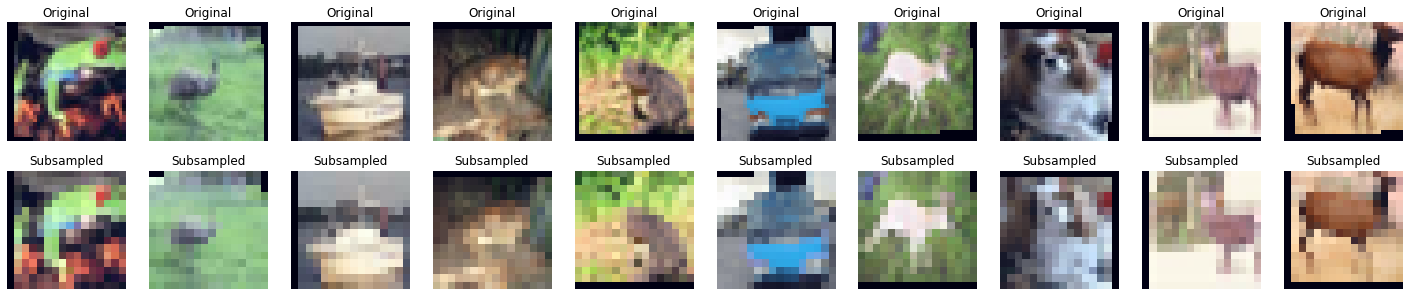

In [47]:
plot_subsample(images, 'max', 2)

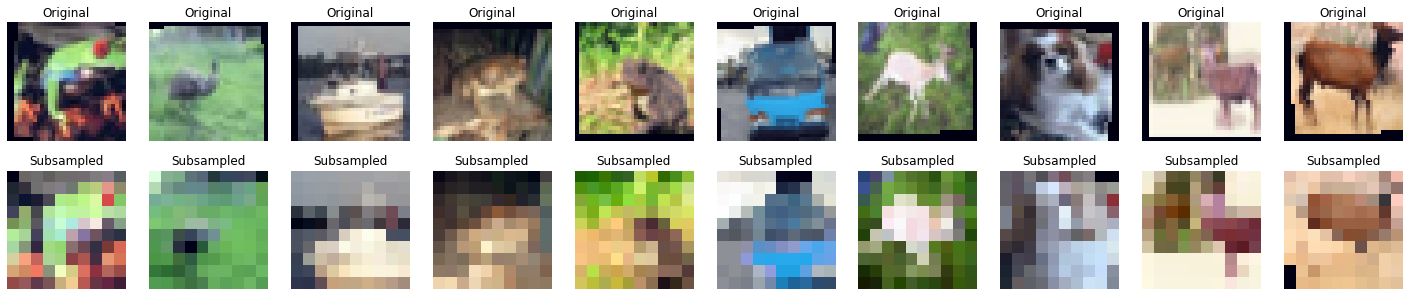

In [48]:
plot_subsample(images, 'max', 3)

### Average/Mean pooling

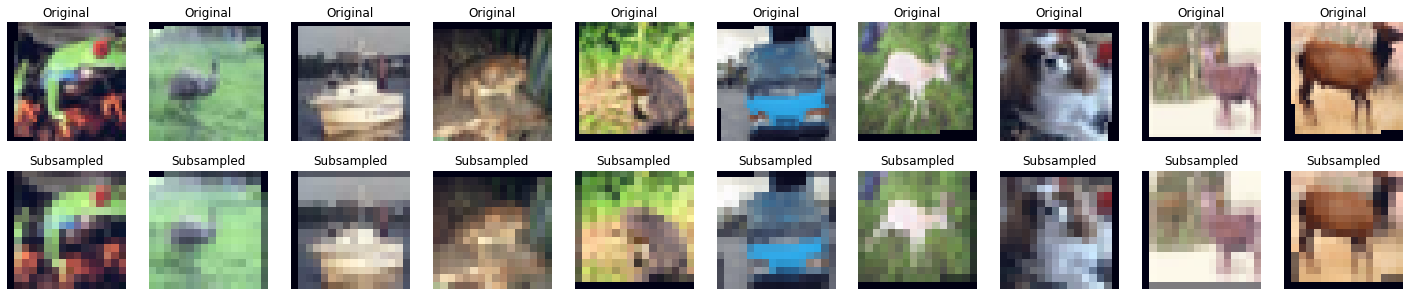

In [49]:
plot_subsample(images, 'avg', 2)

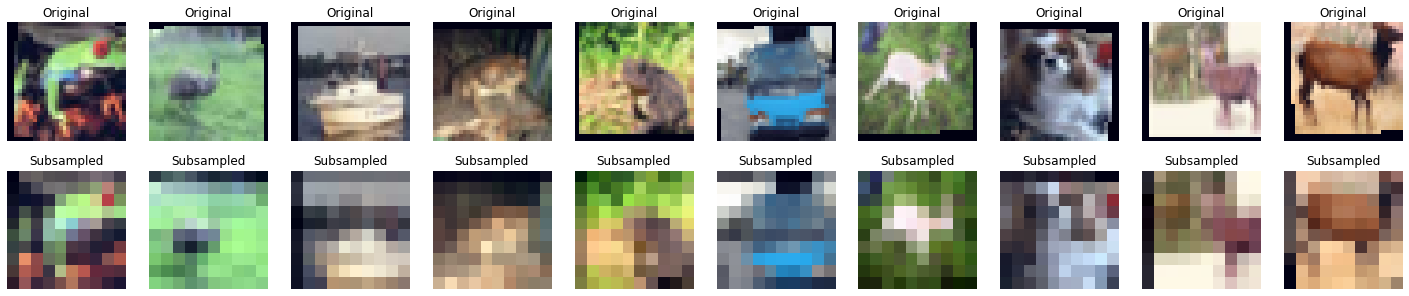

In [51]:
plot_subsample(images, 'avg', 3)

### Creating iterators.

The final bit of the data processing is creating the iterators.

We use a much larger batch size here than in previous models. 

***Generally, when using a GPU, a larger batch size means our model trains faster.**

Our model has significantly more parameters and the images it is training on are much larger, than the previous notebook, so will generally take longer. We offset this as much as we can by using a batch size of 256 instead of 64.


In [52]:
BATCH_SIZE = 265

train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE
)

valid_iterator = data.DataLoader(
    valid_data, batch_size= BATCH_SIZE
)

test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE
)

### Defining our model

The actual model itself is no more difficult to understand than the previous model, `LeNet`. It is made up of convolutional layers, pooling layers and ReLU activation functions.

There are only two new concepts introduced here, `nn.Sequential` and `nn.Dropout`.

We can think of `Sequential` as like our transforms introduced earlier for data augmentation. We provide `Sequential` with multiple layers and when the Sequential module is called it will apply each layer, in order, to the input. There is no difference between using a Sequential and having each module defined in the `__init__` and then called in forward - however it makes the code significantly shorter.

We have one `Sequential` model, features, for all of the convolutional and pooling layers, then we flatten then data and pass it to the `classifier,` another `Sequential` model which is made up of linear layers and the second new concept, `dropout`.

Dropout is a form of [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics). As our models get larger, to perform more accurately on richer datasets, they start having a significantly higher number of parameters. The problem with lots of parameters is that our models begin to overfit. That is, they do not learn general image features whilst learning to classify images but instead simply memorize images within the training set. This is bad as it will cause our model to achieve poor performance on the validation/testing set. To solve this overfitting problem, we use regularization. Dropout is just one method of regularization, other common ones are `L1` regularization, `L2` regularization and `weight decay`.

Dropout works by randomly setting a certain fraction, 0.5 here, of the neurons in a layer to zero. This effectively adds noise to the training of the neural network and causes neurons to learn with "less" data as they are only getting half of the information from a previous layer with dropout applied. It can also be thought of as causing your model to learn multiple smaller models with less parameters.

Dropout is only applied when the model is training. It needs to be "turned off" when validating, testing or using the model for inference.

As mentioned in the previous notebook, during the convolutional and pooling layers the activation function should be placed **after** the pooling layer to reduce computational cost.
In the linear layers, dropout should be applied after the activation function. Although when using ReLU activation functions the same result is achieved if dropout is before or after, see [here](https://sebastianraschka.com/faq/docs/dropout-activation.html).

One last thing to mention is that the very first convolutional layer has an `in_channel` of three. That is because we are handling color images that have three channels `(red, green and blue)` instead of the single channel grayscale images from the MNIST dataset. This doesn't change the way any of the convolutional filter works, it just means the first filter has a depth of three instead of a depth of one.


```

output_with = (image_width - kernel_size + 1) / pool_size

````

In [104]:
class AlexNet(nn.Module):
  def __init__(self, output_dim):
    super(AlexNet, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 3, 2, 1), # in_channels, out_channels, kernel_size, stride, padding
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 192, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 384, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
    )
    
    self.classifier = nn.Sequential(
        nn.Dropout(.5),
        nn.Linear(256 * 2 * 2, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, output_dim),
    )
  
  def forward(self, x):
    x = self.features(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h


### Device

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating a `AlexNet` instance

In [106]:
OUTPUT_DIM = 10
model = AlexNet(OUTPUT_DIM).to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

### Model parameters

Our model has `~23M` parameters which is very small for a computer version task. The AlexNet model has `~44M` parameters

In [107]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(model)

+-----------------------------------+
|          MODEL PARAMETERS         |
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     | 23,272,266 |
| trainable parameters | 23,272,266 |
+----------------------+------------+


### Training the model.

PyTorch's default initialization is usually fine however by manually trying different initialization schemes we can usually squeeze out a slight performance improvement.

We initialize parameters in PyTorch by creating a function that takes in a PyTorch module, checking what type of module it is, and then using the `nn.init` methods to actually initialize the parameters.

For our convolutional layers, we'll initialize the weights from a `Normal` distribution with a standard deviation given by:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

The value of $\text{gain}$ depends on the non-linearity we will be using after the convolutional layer and we simply tell the initialization function that we are using ReLU which sets the gain to $\sqrt{2}$. The fan mode can be either `fan_in` or `fan_out`. `fan_in` is the number of connections coming into the layer and `fan_out` is the number of connections going out of the layer. For the first convolutional layer the input is from `3x3x3` filter, so the `fan_in` is `27` and the output is `64x3x3`, so the `fan_out` is `576`. We leave it to the default `fan_in` mode. This initialization scheme is called Kaiming Normal, also known as He Normal. See the [paper](https://arxiv.org/abs/1502.01852) to learn more about how it was devised.

For the linear layers we initialize with a Normal distribution but this time the standard deviation is given by:

$$\text{gain} \times \sqrt{\frac{2}{\text{fan_in} + \text{fan_out}}}$$
Confusingly, instead of just telling the initialization function which non-linearity we want to use and have it calculate the gain for us, we have to tell it what gain we want to use. Luckily, nn.init has a calculate_gain function which does that for us, and we just tell it we are using ReLUs. This type of initialize scheme is called Xavier Normal, also known as Glorot Normal. See the [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for the theory behind it.


For both types of layer we initialize the bias terms to zeros.

Why do we even need to initialize our parameters this way? See [this article](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79) for a great explanation, but the gist of it is that just like how we normalized our input data to have a mean of 0 and a standard deviation of 1, we also want the outputs of each activation function (and therefore the inputs to the subsequent layer) to also have a mean of 0 and a standard deviation of 1. These initialization schemes, by taking account the number of connections in to and out of a layer as well as the non-linearity used, help achieve this normalization effect when initializing weights.


In [108]:
def initialize_parameters(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
  elif isinstance(m, nn.Linear):
    nn.init.xavier_normal_(m.weight.data, gain= nn.init.calculate_gain('relu')
    )
    nn.init.constant_(m.bias.data, 0)


### Applying the parameters

We just call the `.apply()` method.

In [109]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

### The leaning rate finder.
The code here is taken from a stripped down and slightly modified version of the excellent [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).

**Note:** the learning rate finder is more of an art than a science. It is not going to find an exact learning rate to 10 decimal places which will always give us 100% accuracy - but it is usually going to be better than just picking a learning rate out of thin air.

The most commonly used optimizer used is Adam. Adam's default learning rate is usually a fine choice but, much like how we manually initialized our parameters to potentially get some performance improvement, we can try and calculate an optimal learning rate manually.

How does the learning rate finder work? We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we reach our defined maximum learning rate.

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate - but more on how to do that in a bit.

The losses calculated are usually quite noisy so we actually save the exponentially weighted average of the loss calculated.

We also want to use our initialized parameters, not the ones obtained by upgrading the parameters when performing the learning rate finder. Hence we save the model parameters to disk when initializing the finder and then they are reset to our desired initialized ones just before the `range_test` function returns by loading the initial values from disk.




## `LRFinder`.

In [134]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

### `ExponentialLR`

In [135]:
class ExponentialLR(_LRScheduler):
  def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super(ExponentialLR, self).__init__(optimizer, last_epoch)

  def get_lr(self):
    curr_iter = self.last_epoch
    r = curr_iter / self.num_iter
    return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

### `IteratorWrapper`

In [176]:
class IteratorWrapper:
  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)
  def __next__(self):
      try:
          inputs, labels = next(self._iterator)
      except StopIteration:
          self._iterator = iter(self.iterator)
          inputs, labels, *_ = next(self._iterator)
      return inputs, labels
  def get_batch(self):
      return next(self)


To prepare to use the range finder we define an initial, very low starting learning rate and then create an instance of the optimizer we want to use with that learning rate.

We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [137]:
START_LR = 1e-7
optimizer = torch.optim.Adam(model.parameters(), lr = START_LR)
criterion = nn.CrossEntropyLoss().to(device)

Next, we'll finally use the range finder.

We first create an instance of the finder class with the model, optimizer, loss function and device. Then we use `range_test`
 with the training iterator, the maximum learning rate and the number of iterations we want to use.

In [138]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we can plot the learning rate against the loss.

As our learning rate was scaled up exponentially we want to plot it on a logarithmic scale. We also do not want to plot the last few values as they are usually where the loss is very high and makes it difficult to examine the graph in detail. You can also skip the first few values as nothing interesting happens there.

In [139]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see, the loss begins flat and then begins to decrease rapidly before reaching a minimum and starting to increase.

How can we read this plot and get the optimal learning rate? According to [this article](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html), we should look for the loss begins to flatten, this is around $10^{-2}$ below, and then reduce that by a factor of 10, which gives us a found learning rate of $10^{-3}$ or $0.001$.

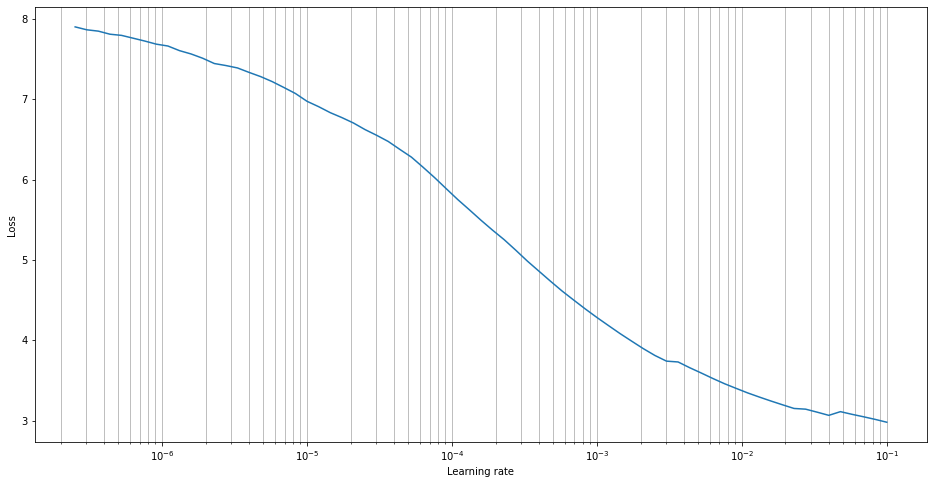

In [140]:
plot_lr_finder(lrs, losses)

We can now create a new optimizer with our found learning rate.

Ironically, the learning rate value we found, $0.001$ is actually Adam's default learning rate!

In [143]:
FOUND_LR = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr = FOUND_LR)

### The rest of the notebook is now similar to what we have done before

### Accuracy function

In [144]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and evaluation loops

In [145]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()

    epoch_loss +=loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Visualizing training

1. function that converts time to string

In [146]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

2. A function that tabulates training

In [147]:
def tabulate_training(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)


### Training loop

In [149]:
EPOCHS = 20
best_valid_loss = float('inf')
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best-model.pt')
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  title = f"EPOCH {epoch+1:02}/{EPOCHS}"
  tabulate_training(column_names, data_rows, title)


+--------------------------------------------+
|                EPOCH 01/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 2.525 |   18.27% | 0:00:27.52 |
| Validation | 1.785 |   30.09% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 02/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 1.639 |   38.47% | 0:00:27.56 |
| Validation | 1.446 |   47.08% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 03/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      

### Evaluating the best model.

In [150]:
model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_training(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.732 |   75.32% |            |
+------+-------+----------+------------+


### Examining the model.

We will do the exact same probing into our model as we did in the previous notebooks: plotting a confusion matrix, plotting the most confident incorrect predictions, using PCA and t-SNE, and viewing the learned weights of our model.

In [151]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [152]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.


In [153]:
pred_labels = torch.argmax(probs, 1)


Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [154]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

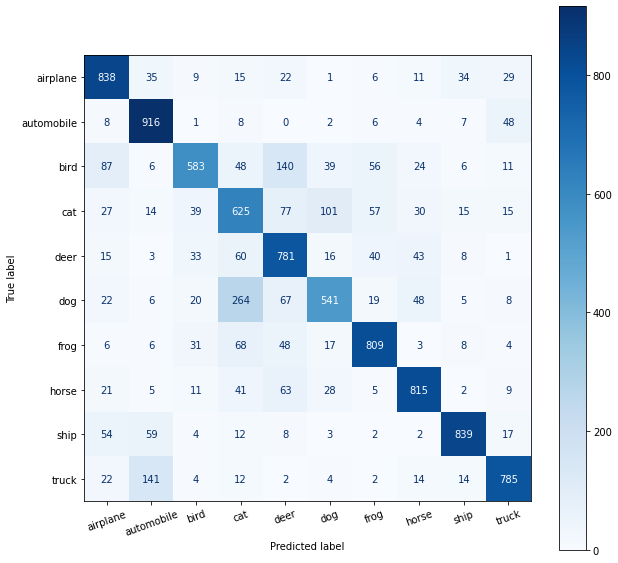

In [155]:
plot_confusion_matrix(labels, pred_labels, classes)

Finding which predictions were correct.

In [156]:
corrects = torch.eq(labels, pred_labels)

In [157]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values
                        )

### Ploting most incorrect predictions

In [160]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_images(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)


Some of the incorrect preditions are those images which were incorrectly labeled in the dataset

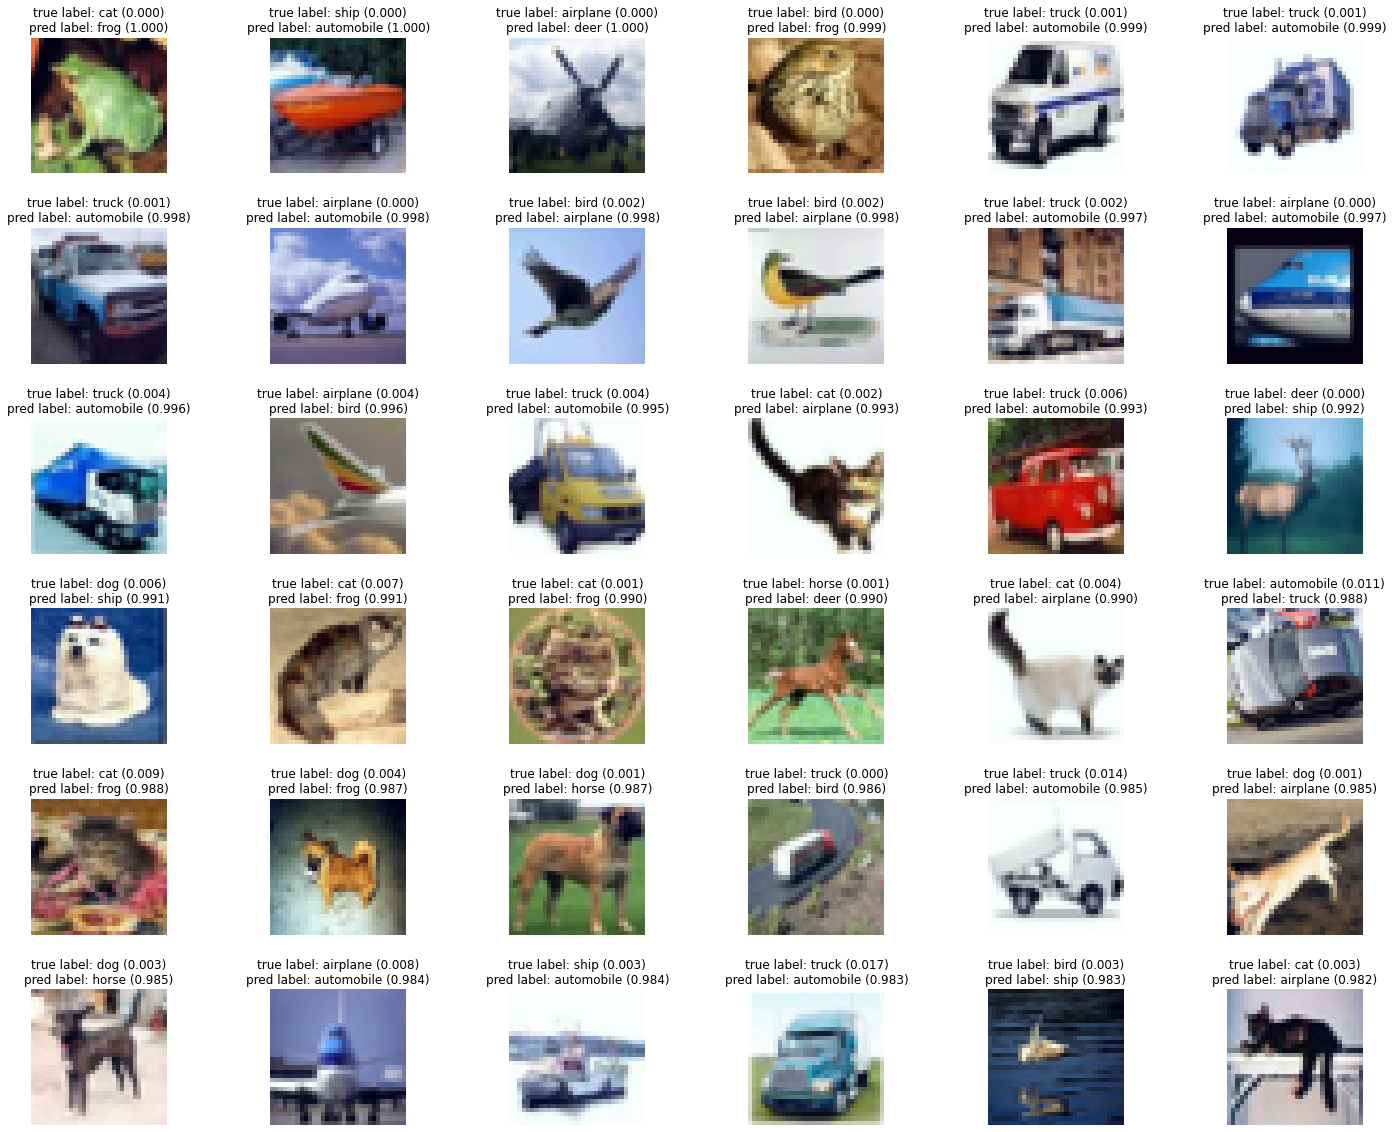

In [161]:
N_IMAGES = 36
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next, we'll get the output and intermediate (after the flatten) representations.


In [162]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels

In [163]:
outputs, intermediates, labels = get_representations(model, 
                                                     train_iterator,
                                                     device)

### We can then perform PCA on them both and plot them.


In [164]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [165]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)
    

Like previous notebooks, the classes seem more separated in the output representations than the intermediate representations.

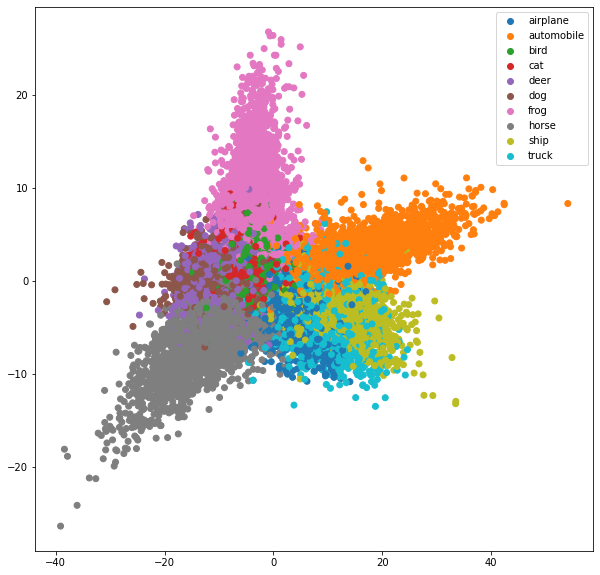

In [166]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

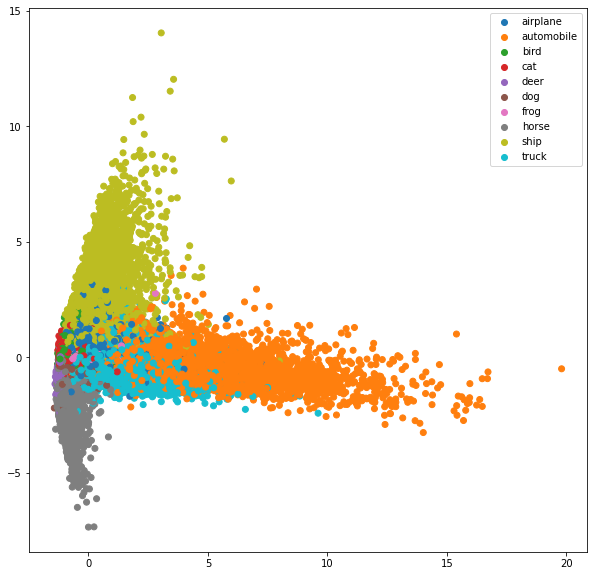

In [167]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

We can do the same with the t-SNE algorithm.

Again, we only use a subset of the data as t-SNE takes a considerable amount of time to compute.

We also see that the classes are more well separated in the output representations compared to the intermediate representations.

In [168]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

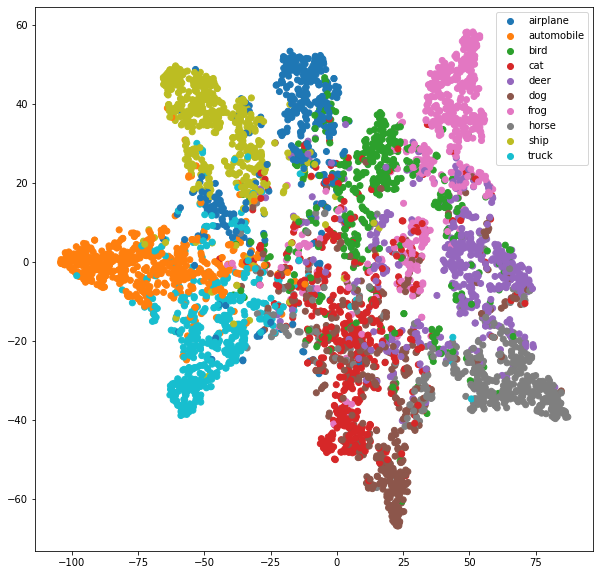

In [169]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images = N_IMAGES)

### We are not going to deep dive in checking the model.

* If you want to [visit this](https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb)

### Real `AlexNet` Model.

In [172]:
import torchvision.models as models

In [174]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Conclusion

In the next notebook we'll implement a popular CNN architecture, `VGG`, and learn about how to actually use pre-trained models on our `dataset`.

### Credits
* [bentrevett](https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb)